In [1]:
from ctypes import *
from scipy.interpolate import interp1d
import pandas as pd
pd.set_option('display.max_rows',None)	#Show all rows
pd.set_option('display.max_columns',None)	#Show all cols
pd.set_option('display.max_colwidth', None)	#不要truncate cell
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import numpy as np
import json
import os
import warnings
warnings.filterwarnings("ignore")

import scipy.io
import h5py
from mat4py import loadmat

from tqdm import tqdm
import datetime
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error


# Load Input/Output/Calibrating Param Info

In [2]:
def read_json(file):
    """
    read json conf file
    :param file: str
    :return:
    """
    return json.load(open(file, "r", encoding="UTF-8"))

tmp=read_json("calibration_vars.json")

global CalibrationNames
CalibrationNames=list(tmp['calibration'].keys())
global InputNames
InputNames=tmp['input']['struct']
global OutputNames
OutputNames=tmp['output']['struct']

print('Params to be Calibrated:',CalibrationNames,'\n')
print('Params to be Input:',InputNames,'\n')
print('Params to be Output:',OutputNames,'\n')

print('initial calibrated values：',[float(item['value']) for item in tmp['calibration'].values()])
del tmp

Params to be Calibrated: ['Jmf', 'Jmr', 'Jwf', 'Jwr', 'btf', 'btr', 'cflh', 'cfrh', 'cp_f', 'cp_r', 'crlh', 'crrh', 'f0', 'f1', 'f2', 'kflh', 'kfrh', 'krlh', 'krrh'] 

Params to be Input: ['PEUFTorque', 'PEURTorque', 'RollingRadius', 'Mue', 'WheelBrkPFrntLe', 'WheelBrkPFrntRi', 'WheelBrkPReLe', 'WheelBrkPReRi', 'WhlSpdFrntLeInit', 'WhlSpdFrntRiInit', 'WhlSpdReLeInit', 'WhlSpdReRiInit', 'VehSpdInit'] 

Params to be Output: ['WhlSpdFrntLe', 'WhlSpdFrntRi', 'WhlSpdReLe', 'WhlSpdReRi', 'PEUFMotSpd', 'PEURMotSpd', 'LgtA', 'VehSpd'] 

initial calibrated values： [0.04701, 0.04701, 1.8, 1.8, 0.0017453292519943296, 0.0017453292519943296, 3.4586, 3.4586, 35.25, 18.14, 3.4586, 3.4586, 360.0, 2.074, 0.0334, 6818.0, 6818.0, 6818.0, 6818.0]


In [3]:
var_config=pd.DataFrame({
    'var':['Jmf', 'Jmr', 'Jwf', 'Jwr', 'btf', 'btr', 'cflh', 'cfrh', 'cp_f','cp_r', 
           'crlh', 'crrh', 'f0', 'f1', 'f2', 'kflh', 'kfrh', 'krlh','krrh'],
    'init':[0.042, 0.04, 1.87, 1.87, 0.0017453292519943296, 0.0017453292519943296, 80, 80, 35.25, 18.14, 80, 
            80, 324.0, 1.074, 0.0224, 8818.0, 8818.0, 6818.0, 6818.0]})

In [4]:
#Set tuning range
var_config['lower']=var_config['init']*0.33
var_config['upper']=var_config['init']*3

var_config.loc[var_config['var']=='cp_f','lower']=var_config.loc[var_config['var']=='cp_f','init']
var_config.loc[var_config['var']=='cp_f','upper']=var_config.loc[var_config['var']=='cp_f','init']+0.1
var_config.loc[var_config['var']=='cp_r','lower']=var_config.loc[var_config['var']=='cp_r','init']
var_config.loc[var_config['var']=='cp_r','upper']=var_config.loc[var_config['var']=='cp_r','init']+0.1

var_config

,var,init,lower,upper
0,Jmf,0.042000,0.013860,0.126000
1,Jmr,0.040000,0.013200,0.120000
2,Jwf,1.870000,0.617100,5.610000
3,Jwr,1.870000,0.617100,5.610000
4,btf,0.001745,0.000576,0.005236
5,btr,0.001745,0.000576,0.005236
6,cflh,80.000000,26.400000,240.000000
7,cfrh,80.000000,26.400000,240.000000
8,cp_f,35.250000,35.250000,35.350000
9,cp_r,18.140000,18.140000,18.240000


In [5]:
tmp=['Jmf', 'Jmr', 'Jwf', 'Jwr', 'btf', 'btr', 'cflh', 'cp_f',
       'cp_r', 'crlh', 'f0', 'f1', 'f2', 'kflh', 'krlh']
lower_bounds=[var_config.loc[var_config['var']==var,'lower'].values[0] for var in tmp]
upper_bounds=[var_config.loc[var_config['var']==var,'upper'].values[0] for var in tmp]

# Config Input/Output Scheme

In [6]:
global ModelInputScheme
ModelInputScheme=[('PEUFTorque', c_double),
                ('PEURTorque', c_double),
                ('RollingRadius', c_double),
                ('Mue', c_double),
                ('WheelBrkPFrntLe', c_double),
                ('WheelBrkPFrntRi', c_double),
                ('WheelBrkPReLe', c_double),
                ('WheelBrkPReRi', c_double),
                ('WhlSpdFrntLeInit', c_double),      
                ('WhlSpdFrntRiInit', c_double),     
                ('WhlSpdReLeInit', c_double),     
                ('WhlSpdReRiInit', c_double),     
                ('VehSpdInit',c_double)     
                ]

global ModelOutputScheme
ModelOutputScheme=[
        ('WhlSpdFrntLe', c_double),     
        ('WhlSpdFrntRi', c_double),     
        ('WhlSpdReLe', c_double),     
        ('WhlSpdReRi', c_double),     
        ('PEUFMotSpd', c_double),
        ('PEURMotSpd', c_double),
        ('LgtA', c_double),
        ('VehSpd', c_double)     
    ]

# Load Data

In [13]:
#data=[pd.read_csv(r'data/cleaned/2023-06-01_10-42-42_玛吉斯_force大牌_滑行测试_1000Hz.csv').iloc[::10,:].reset_index(drop=True)]
data=[pd.read_csv(r'data/cleaned/2023-06-01_10-23-48_玛吉斯_force大牌_加速性能测试_1000Hz.csv').iloc[::10,:].reset_index(drop=True)]

In [14]:
data[0].describe()

,PEUFTorque,PEURTorque,RollingRadius,Mue,WheelBrkPFrntLe,WheelBrkPFrntRi,WheelBrkPReLe,WheelBrkPReRi,WhlSpdFrntLeInit,WhlSpdFrntRiInit,WhlSpdReLeInit,WhlSpdReRiInit,VehSpdInit,WhlSpdFrntLe,WhlSpdFrntRi,WhlSpdReLe,WhlSpdReRi,PEUFMotSpd,PEURMotSpd,LgtA,VehSpd
count,45512.000000,45512.000000,4.551200e+04,4.551200e+04,45512.000000,45512.000000,45512.000000,45512.000000,4.551200e+04,45512.00000,4.551200e+04,4.551200e+04,4.551200e+04,45512.000000,45512.000000,45512.000000,45512.000000,45512.000000,45512.000000,45512.000000,45512.000000
mean,13.325244,29.023283,3.550000e-01,8.800000e-01,2.581113,2.581113,2.569544,2.569544,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,54.165647,53.966039,54.154943,53.928683,4243.277962,3892.271788,0.001315,54.047217
std,130.983578,78.858459,5.551176e-17,4.440941e-16,7.870217,7.870217,7.870976,7.870976,1.776376e-15,0.00000,1.776376e-15,1.776376e-15,1.776376e-15,34.292915,34.531508,34.392657,34.633097,2696.845813,2483.208368,0.242881,34.460345
min,-184.375000,-193.875000,3.550000e-01,8.800000e-01,0.000000,0.000000,0.000000,0.000000,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,0.000000,0.000000,0.000000,0.000000,-54.000000,-18.000000,-0.709000,0.000000
25%,-75.350000,0.000000,3.550000e-01,8.800000e-01,0.000000,0.000000,0.000000,0.000000,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,26.381250,25.537500,26.212500,25.481250,2041.850000,1860.300000,-0.101000,25.875000
50%,-33.225000,0.000000,3.550000e-01,8.800000e-01,0.000000,0.000000,0.000000,0.000000,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,49.500000,49.500000,49.500000,49.500000,3879.400000,3564.600000,-0.081000,49.500000
75%,158.900000,74.406250,3.550000e-01,8.800000e-01,0.500000,0.500000,0.500000,0.500000,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,79.762500,79.650000,79.762500,79.762500,6256.000000,5743.100000,0.218000,79.762500
max,222.500000,213.250000,3.550000e-01,8.800000e-01,55.200000,55.200000,55.300000,55.300000,8.775000e+00,8.71875,8.662500e+00,8.662500e+00,8.775000e+00,137.306250,137.306250,137.306250,137.081250,10730.000000,9847.000000,0.434000,137.081250


# Model Class

In [24]:
class ModelInputStruct(Structure):
    _fields_ = ModelInputScheme

class ModelOutputStruct(Structure):
    _fields_ = ModelOutputScheme
    

class ModelPredict:
    def __init__(self,data,loss_func=None,metric_func=None,show_plots=False):
        """
            data:List[pd.DataFrame]
            loss_func:Function(y_true:pd.DataFrame,y_pred:pd.DataFrame), return float
            metric_func:Function(y_true:pd.DataFrame,y_pred:pd.DataFrame), return pd.Series with index=y_true.columns
            show_plots:bool, whether to show pred vs true lineplots
        """
        
        self.mdl_input = ModelInputStruct()
        self.mdl_output = ModelOutputStruct()
        self.calibration_vars = read_json("calibration_vars.json")
        
        self.CalibrationNames=list(self.calibration_vars['calibration'].keys())
        self.InputNames=[item[0] for item in self.mdl_input._fields_]
        self.OutputNames=[item[0] for item in self.mdl_output._fields_]

        
        self.data=data
        self.loss=loss_func
        self.metric=metric_func
        self.show_plots=show_plots
    
    def calibrate_pred(self,pred_single_point):
        """ Func:Calibrate pred according to constraints
            Input:
                single_point:pd.Series #pd.Series(data,index=self.OutputNames)
            Output:
                single_point:pd.Series #pd.Series(data,index=self.OutputNames)
        """
        
        veh=pred_single_point['VehSpd']
        # constraints={
        #     'PEUFMotSpd':(73.74*veh-700,73.74*veh+700),
        #     'PEURMotSpd':(68.2*veh-600,68.2*veh+600),
        #     'WhlSpdFrntLe':(veh-5,veh+5),
        #     'WhlSpdFrntRi':(veh-5,veh+5),
        #     'WhlSpdReLe':(veh-5,veh+5),
        #     'WhlSpdReRi':(veh-5,veh+5)
        # }
        #for key,constraint in constraints.items():
                #     lower_bound,upper_bound=constraint
                #     pred_single_point[key]=max(pred_single_point[key],lower_bound)
                #     pred_single_point[key]=min(pred_single_point[key],upper_bound)
        constraints={
                    'PEUFMotSpd':73.74*veh,
                    'PEURMotSpd':68.2*veh,
                    'WhlSpdFrntLe':veh,
                    'WhlSpdFrntRi':veh,
                    'WhlSpdReLe':veh,
                    'WhlSpdReRi':veh
                }
        
        for key,constraint in constraints.items():
            if np.isnan(pred_single_point[key]):pre_single_point[key]=constraints[key]
        return pred_single_point

    def __gettype(self,var_config,name):
        """Func:Return ctypes of var according to config. Used for getting type from self.mdl_input or self.mdl_output
        """
        for var,vartype in var_config:
            if var==name:return vartype
        
    def test_one_step(self,data_single_point):
        """ Func:Predict on one time step
            Input:
                data_single_point:pd.Series #pd.Series(data,index=self.InputNames)
            Output:
                res:pd.Series(data,index=self.OutputNames)
        """
        for var in self.InputNames:
            type_statement=self.__gettype(self.mdl_input._fields_,var)
            setattr(self.mdl_input,var,type_statement(data_single_point[var]))
        self.lib.predict(pointer(self.mdl_input), pointer(self.mdl_output))
        res=[getattr(self.mdl_output,var) for var in self.OutputNames]
        res=pd.Series(res,index=self.OutputNames)
        res=self.calibrate_pred(res)
        
        return res
    
    def test_all_steps(self,datum):
        """Func:Self-looped prediction on all time steps
           Input:
               datum:pd.dataFrame(df,columns=self.InputNames)
           Output:
               Tuple[pred_values:pd.DataFrame(df,columns=self.OutputNames),
                     true_values:pd.DataFrame(df,columns=self.OutputNames)]
        """
        
        pred_values=[]
        true_values=[]
        for i in range(datum.shape[0]-1):
            datum_single_point=datum.iloc[i][self.InputNames]
            if i>0:
                # datum_single_point['WhlSpdFrntLeInit']=pred_value['WhlSpdFrntLe']
                # datum_single_point['WhlSpdFrntRiInit']=pred_value['WhlSpdFrntRi']
                # datum_single_point['WhlSpdReLeInit']=pred_value['WhlSpdReLe']
                # datum_single_point['WhlSpdReRiInit']=pred_value['WhlSpdReRi']
                # datum_single_point['VehSpdInit']=pred_value['VehSpd']
                datum_single_point['WhlSpdFrntLeInit']=None
                datum_single_point['WhlSpdFrntRiInit']=None
                datum_single_point['WhlSpdReLeInit']=None
                datum_single_point['WhlSpdReRiInit']=None
                datum_single_point['VehSpdInit']=None
                
            pred_value=self.test_one_step(datum_single_point)
            pred_values.append(pred_value)
            true_values.append(datum.iloc[i+1][self.OutputNames])
            
        pred_values=pd.DataFrame(pred_values,columns=self.OutputNames)
        true_values=pd.DataFrame(true_values,columns=self.OutputNames)
        pred_values.reset_index(drop=True,inplace=True)
        true_values.reset_index(drop=True,inplace=True)
        
        if self.show_plots:self.plot_loss(true_values,pred_values)
        return (true_values.iloc[1250:],pred_values.iloc[1250:])                 #抛弃系统未稳定阶段的值
    
    def get_calibrated_params(self):
        """
            Output:
                calibrated_params: pd.Series  #params to be calibrated and their current values
        """
        calibrated_params=[]
        for var in self.CalibrationNames:
            __type = self.calibration_vars['calibration'][var]["type"]
            __size = self.calibration_vars['calibration'][var]["size"]
            idx=self.CalibrationNames.index(var)
            #State var type
            type_statement = None
            types={'int':c_int,
                  'float':c_float,
                  'double':c_double,
                  'unsigned char':c_bool,
                  'char':c_char,
                  'long':c_long,
                  'long long':c_longlong,
                  'short':c_short,
                  'uint8':c_uint8}
            if __size==1:type_statement=types[__type.lower()]                   #scalar param
            else:type_statement=types[__type.lower()]*__size                    #vector param
            if type_statement is None:raise NotImplementedError(f"cannot found matched statement for calibration parameter '{var}'")
            #Set values
            calibrated_params.append(type_statement.in_dll(self.lib, var))
        calibrated_params=pd.Series(calibrated_params,index=self.CalibrationNames)
        return calibrated_params
    
    def set_calibrated_params(self,params):
        """
            Func: Set calibrated params into the model
            Input:
                params: List[float,List[float]]            #order of calibrated params should correspond to self.CalibrationNames
        """
        for var in self.CalibrationNames:
            __type = self.calibration_vars['calibration'][var]["type"]
            __size = self.calibration_vars['calibration'][var]["size"]
            idx=self.CalibrationNames.index(var)
            #State var type
            type_statement = None
            types={'int':c_int,
                  'float':c_float,
                  'double':c_double,
                  'unsigned char':c_bool,
                  'char':c_char,
                  'long':c_long,
                  'long long':c_longlong,
                  'short':c_short,
                  'uint8':c_uint8}
            if __size==1:type_statement=types[__type.lower()]                   #scalar param
            else:type_statement=types[__type.lower()]*__size                    #vector param
            if type_statement is None:raise NotImplementedError(f"cannot found matched statement for calibration parameter '{var}'")
            #Set values
            tmp = type_statement.in_dll(self.lib, var)
            cali_var_ptr = pointer(tmp)
            if __size == 1:cali_var_ptr[0] = type_statement(params[idx])       #Set scalar value
            else:cali_var_ptr[0] = type_statement(*params[idx])                #Set vector value
     
    def get_metric(self,true_values,pred_values):
        """Func: get MAE for the output vars
           Output:
               metric:Anything
        """
        if self.metric is None:return pd.Series(None)
        return self.metric(true_values,pred_values)
    
    def get_loss(self,true_values,pred_values):
        """Func: get MAPE
           Output:
               loss:float
        """
        if self.loss is None:return None
        return self.loss(true_values,pred_values)
    
    def plot_loss(self,true_values,pred_values):
        for col in self.OutputNames:
            plt.figure(figsize=(10,2))
            plt.plot(list(range(pred_values.shape[0])),pred_values[col],label='Pred')
            plt.plot(list(range(true_values.shape[0])),true_values[col],label='True')
            plt.title(col)
            plt.legend()
            plt.show()
        
#         for col in self.OutputNames:
#             true_value=pd.DataFrame({'idx':true_values.index,col:true_values[col]})
#             true_value['source']='True'
#             pred_value=pd.DataFrame({'idx':pred_values.index,col:pred_values[col]})
#             pred_value['source']='Pred'
            
#             tmp=pd.concat([true_value,pred_value],ignore_index=True)
#             fig=px.line(tmp,x='idx',y=col,markers=False,color='source',title=col)
#             fig.update_traces(line=dict(width=1))
#             fig.show()
    
    def run_one_datum(self,datum):
        """
            Func:run on one datum and return loss & metric
            Output:
                loss:Anything
                metric:pd.Series
        """
        self.lib = cdll.LoadLibrary(r'source/libTransModel100Hz.so')
        self.lib.init()
        self.set_calibrated_params(self.params)
        true_values,pred_values=self.test_all_steps(datum)
        loss=self.get_loss(true_values,pred_values)
        metric=self.get_metric(true_values,pred_values)
        self.lib.terminate()
        return loss,metric
    
    def run_all_data_loss(self,params):
        """
            Func:run on all data and return loss
            Input:
                params:list
            Output:
                loss: float
        """
        self.params=params
        losses=[]
        for datum in self.data:
            loss,metric=self.run_one_datum(datum)
            losses.append(loss)
        return np.mean(losses)

    def run_all_data_metric(self,params):
        """
            Func:run on all data and return metric
            Input:
                params:list
            Output:
                metric:pd.Series(index=customized)
        """
        self.params=params
        metrics=[]
        for datum in self.data:
            loss,metric=self.run_one_datum(datum)
            metrics.append(metric)
        metrics=pd.DataFrame(metrics).mean(axis=0)
        return metrics

# Benchmark

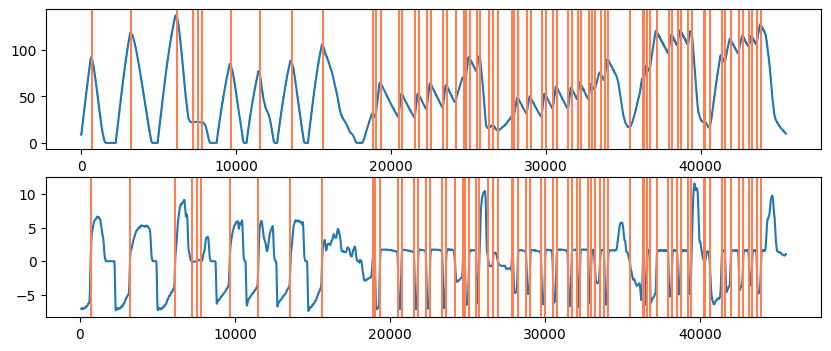

In [16]:
#定位转速抖动点可视化
tmp=(data[0]['VehSpd'].shift(50)-data[0]['VehSpd']).rolling(50).mean()      #0.5s速度差接0.5秒均值平滑

tmp2=np.where(tmp*tmp.shift(1)<0)

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(data[0]['VehSpd'])
for loc in tmp2[0]:
    plt.axvline(loc,color='coral')
plt.subplot(2,1,2)
plt.plot(tmp)
for loc in tmp2[0]:
    plt.axvline(loc,color='coral')
plt.show()

In [25]:
def calculate_MotSpdFollowing(true_values,pred_values):
    """Func:Calculate MotSpdFollowing Loss (abs(PearsonCoef-1))
       Output:
           PEUF_following:-1<=float<=1
           PEUR_following:-1<=float<=1
    """
    #2s window after the sign of MotAcc changes, turbulence of PEUFMotSpd & PEURMotSpd
    acceleration=(true_values['VehSpd'].shift(50)-true_values['VehSpd']).rolling(50).mean()   #0.5s MotSpd diff with 0.5s mean rolling
    acceleration_changing_point=np.where(acceleration*acceleration.shift(1)<0)[0]             #Locate the start points of turbulent intervals
    
    MotSpd_turbulent_segment=pd.DataFrame({'start':acceleration_changing_point,
                                           'end':acceleration_changing_point+200})            #2s window after the sign of MotAcc changes as turbulent intervals
    #Merge overlapped intervals
    MotSpd_turbulent_segment=MotSpd_turbulent_segment.sort_values('start',ascending=True)
    MotSpd_turbulent_segment["group"]=(MotSpd_turbulent_segment["start"]>MotSpd_turbulent_segment["end"].shift()).cumsum()
    MotSpd_turbulent_segment=MotSpd_turbulent_segment.groupby("group").agg({"start":"min", "end": "max"}).values
    
    
    MotSpd_turbulent_true_values=[true_values[['PEUFMotSpd','PEURMotSpd']].iloc[start:end] 
                                  for start,end in MotSpd_turbulent_segment]
    MotSpd_turbulent_true_values=pd.concat(MotSpd_turbulent_true_values,ignore_index=True)
    MotSpd_turbulent_pred_values=[pred_values[['PEUFMotSpd','PEURMotSpd']].iloc[start:end] 
                                  for start,end in MotSpd_turbulent_segment]
    MotSpd_turbulent_pred_values=pd.concat(MotSpd_turbulent_pred_values,ignore_index=True)
    
    PEUF_following=np.abs(np.corrcoef(MotSpd_turbulent_true_values['PEUFMotSpd'],MotSpd_turbulent_pred_values['PEUFMotSpd'])[0,1]-1)
    PEUR_following=np.abs(np.corrcoef(MotSpd_turbulent_true_values['PEURMotSpd'],MotSpd_turbulent_pred_values['PEURMotSpd'])[0,1]-1)
    return (PEUF_following,PEUR_following)
def customized_metric(true_values,pred_values):
    """
        Require global metric benchmark, which is a pd.Series
        Input:
            true_values:pd.DataFrame(,columns=global OutputNames)
            pred_values:pd.DataFrame(,columns=global OutputNames)
        Output:
            metric_series:pd.Series(,columns=customized)
    """
    ##############customized metric##############
    #Mae of raw ouput signals
    metric_series=pd.Series([mean_absolute_error(true_values[col],pred_values[col]) for col in true_values.columns],index=true_values.columns)
    #MotSpd following loss
    metric_series['PEUFMotSpdFollowing'],metric_series['PEURMotSpdFollowing']=calculate_MotSpdFollowing(true_values,pred_values)
    
    return metric_series

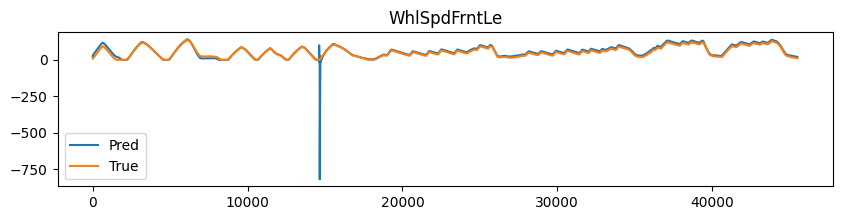

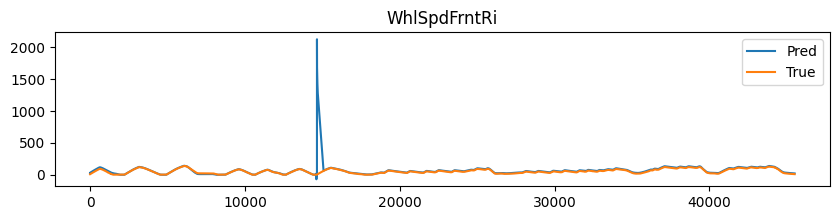

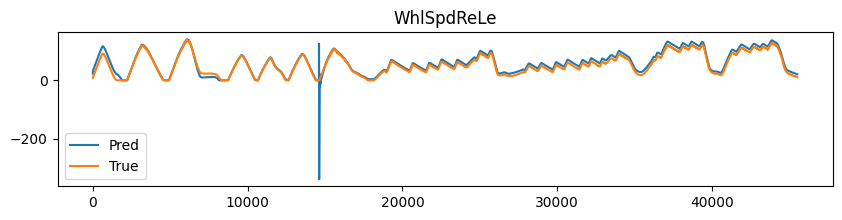

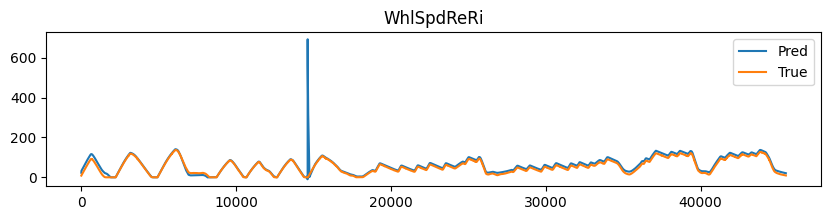

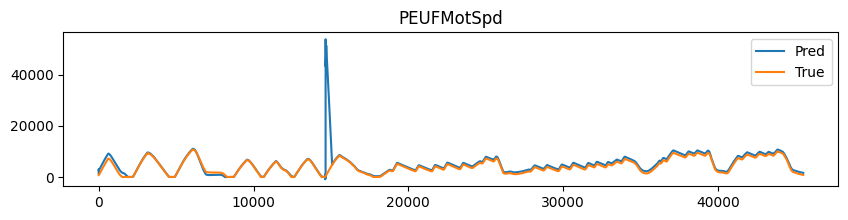

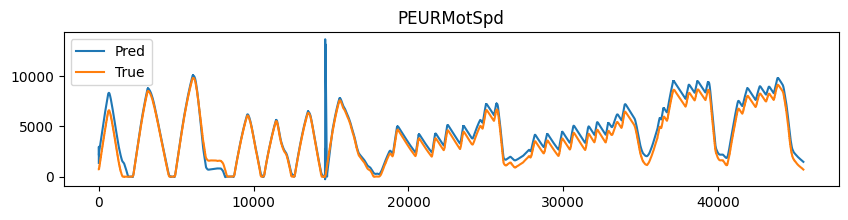

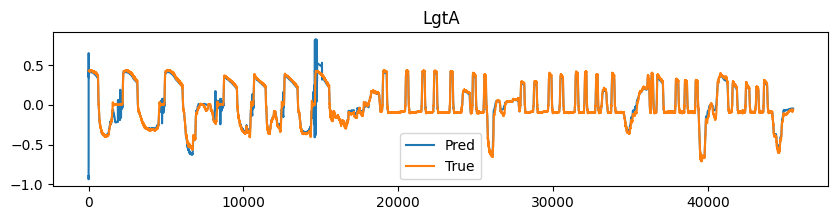

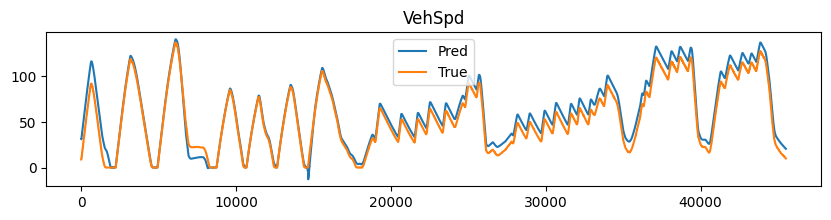

Time Consumed: 0:01:02.600720 s


WhlSpdFrntLe             7.336362
WhlSpdFrntRi            14.213551
WhlSpdReLe               7.222489
WhlSpdReRi               7.877835
PEUFMotSpd             803.959090
PEURMotSpd             513.638700
LgtA                     0.020532
VehSpd                   7.088159
PEUFMotSpdFollowing      0.009166
PEURMotSpdFollowing      0.008913
dtype: float64

In [26]:
#Inital Param Benchmark
init_params=np.array([0.042, 0.04, 1.87, 1.87, 0.0017453292519943296, 0.0017453292519943296, 80, 80, 35.25, 18.14, 80, 
            80, 324.0, 1.074, 0.0224, 8818.0, 8818.0, 6818.0, 6818.0])

start_time = datetime.datetime.now()
model_instance=ModelPredict(data,metric_func=customized_metric,show_plots=True)
global metric_benchmark
metric_benchmark=model_instance.run_all_data_metric(init_params)
del model_instance

print('Time Consumed:',datetime.datetime.now()-start_time,'s')

display(metric_benchmark)

# Optimization

In [17]:
def customed_loss(true_values,pred_values):
    """
        Require global metric benchmark, which is a pd.Series
        Input:
            true_values:pd.DataFrame(,columns=global OutputNames)
            pred_values:pd.DataFrame(,columns=global OutputNames)
        Output:
            loss:float
    """
    ##############customized loss##############
    weights={key:value for key,value in zip(['WhlSpdFrntLe','WhlSpdFrntRi','WhlSpdReLe','WhlSpdReRi',
                                             'PEUFMotSpd','PEURMotSpd','LgtA','VehSpd',
                                             'PEUFMotSpdFollowing','PEURMotSpdFollowing'],
                                            [1,1,1,1,5,5,2,1,1,1])}
    loss=0
    for col in ['WhlSpdFrntLe','WhlSpdFrntRi','WhlSpdReLe','WhlSpdReRi','PEUFMotSpd','PEURMotSpd','LgtA','VehSpd']:
        loss=loss+weights[col]*mean_absolute_error(true_values[col],pred_values[col])/metric_benchmark[col]
    
    PEUFMotSpdFollowing,PEURMotSpdFollowing=calculate_MotSpdFollowing(true_values,pred_values) 
    loss=loss+weights['PEUFMotSpdFollowing']*PEUFMotSpdFollowing/metric_benchmark['PEUFMotSpdFollowing']
    loss=loss+weights['PEURMotSpdFollowing']*PEURMotSpdFollowing/metric_benchmark['PEURMotSpdFollowing']
       
    return loss
    
def target_func(params_partial):
    #由于sko的约束不好用，所以在此处通过对传入参数进行复制的方式，实现几个参数相等关系
    params_partial=list(params_partial)
    params_partial.insert(7,params_partial[6])
    params_partial.insert(11,params_partial[10])
    params_partial.insert(16,params_partial[15])
    params_partial.insert(18,params_partial[17])
    model_instance=ModelPredict(data,loss_func=customed_loss)
    loss=model_instance.run_all_data_loss(params_partial)
    del model_instance
    return loss

In [18]:
list(enumerate(['Jmf', 'Jmr', 'Jwf', 'Jwr', 'btf', 'btr', 'cflh', 'cfrh', 'cp_f', 'cp_r', 'crlh', 'crrh', 'f0', 'f1', 'f2', 'kflh', 'kfrh', 'krlh', 'krrh']))

[(0, 'Jmf'),
 (1, 'Jmr'),
 (2, 'Jwf'),
 (3, 'Jwr'),
 (4, 'btf'),
 (5, 'btr'),
 (6, 'cflh'),
 (7, 'cfrh'),
 (8, 'cp_f'),
 (9, 'cp_r'),
 (10, 'crlh'),
 (11, 'crrh'),
 (12, 'f0'),
 (13, 'f1'),
 (14, 'f2'),
 (15, 'kflh'),
 (16, 'kfrh'),
 (17, 'krlh'),
 (18, 'krrh')]

In [19]:
#Set constraints
#x:['Jmf', 'Jmr', 'Jwf', 'Jwr', 'btf', 'btr', 'cflh', 'cfrh', 'cp_f', 'cp_r', 'crlh', 'crrh', 'f0', 'f1', 'f2', 'kflh', 'kfrh', 'krlh', 'krrh']
# constraint_eq=(
#     lambda x:(x[6]-x[7])**2+(x[10]-x[11])**2+(x[15]-x[16])**2+(x[17]-x[18])**2-36   #(x[8]-35.24)**2+(x[9]-18.14)**2-36, 
#              #cflh=cfrh      #crlh=crrh       #kflh=kfrh        #krlh=krrh      #cp_f=35.24     #cp_r=18.14
# )

In [ ]:
from sko import PSO,tools

start_time = datetime.datetime.now()
tools.set_run_mode(target_func,'multiprocessing')
opt_algorithm=PSO.PSO(func=target_func,n_dim=len(CalibrationNames)-4,pop=40,
               max_iter=80,lb=lower_bounds,ub=upper_bounds,w=1,c1=2,c2=2
                      #,constraint_eq=constraint_eq
                     )

# Execute Optimization Algorithm
opt_algorithm.run()

print('Time Consumed:',datetime.datetime.now()-start_time,'s')

# Evaluation

In [ ]:
# Plot loss curve in the epochs
plt.plot(opt_algorithm.gbest_y_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Tuned Performance:',opt_algorithm.gbest_y)

In [ ]:
#Show tuned param table
#基于约束关系补全参数列表
tuned_params=list(opt_algorithm.best_x)
tuned_params.insert(7,tuned_params[6])
tuned_params.insert(11,tuned_params[10])
tuned_params.insert(16,tuned_params[15])
tuned_params.insert(18,tuned_params[17])
    
params_tb=pd.DataFrame({'var':var_config['var'],'Init':var_config['init'],'Tuned':tuned_params})

params_tb.to_csv('params_tb.csv',index=False)
params_tb

In [ ]:
#Evaluate with tuned params
model_instance=ModelPredict(data,metric_func=customized_metric,show_plots=True)
metric_tuned=model_instance.run_all_data_metric(tuned_params)
del model_instance

In [ ]:
metric_tuned

In [ ]:
#Performance comparison
performance_table=pd.DataFrame({'InitMae':metric_benchmark.values,'TunedMae':metric_tuned.values,'MaeDeclined':1-metric_tuned.values/metric_benchmark.values})
performance_table.index=metric_benchmark.index
performance_table

# Test

In [25]:
data=[pd.read_csv(r'data/cleaned/2023-06-01_10-23-48_玛吉斯_force大牌_加速性能测试_1000Hz.csv').iloc[::10,:].reset_index(drop=True)]

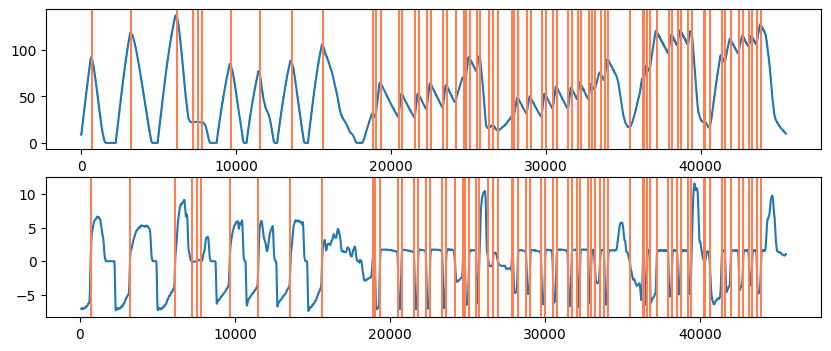

In [26]:
#定位转速抖动点
tmp=(data[0]['VehSpd'].shift(50)-data[0]['VehSpd']).rolling(50).mean()      #0.5s速度差接0.5秒均值平滑

tmp2=np.where(tmp*tmp.shift(1)<0)

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(data[0]['VehSpd'])
for loc in tmp2[0]:
    plt.axvline(loc,color='coral')
plt.ylabel('VehSpd')
plt.subplot(2,1,2)
plt.plot(tmp)
for loc in tmp2[0]:
    plt.axvline(loc,color='coral')
plt.ylabel('VehSpd')
plt.show()

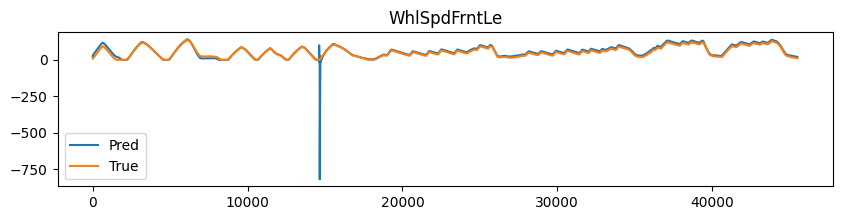

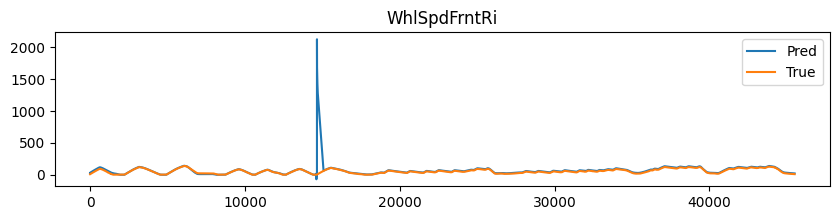

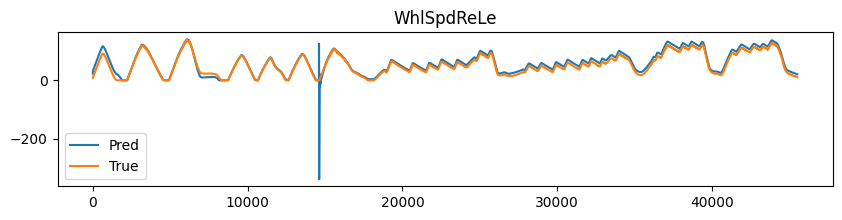

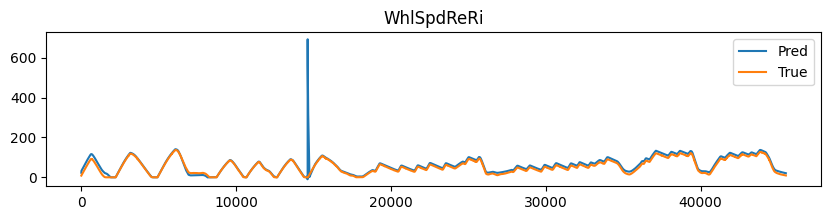

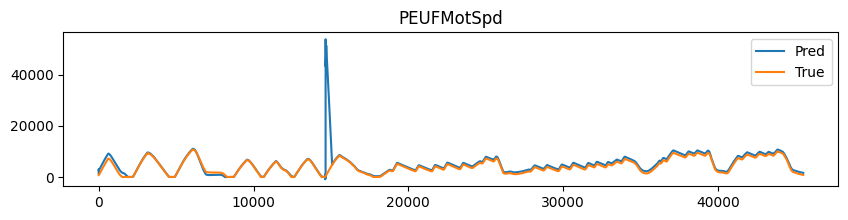

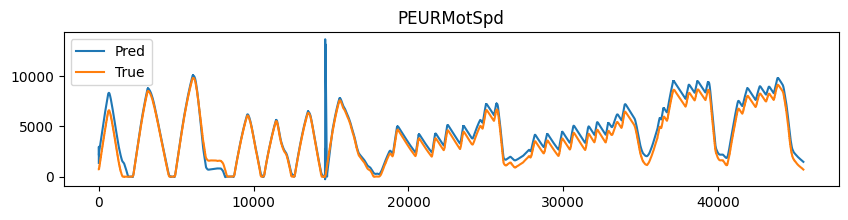

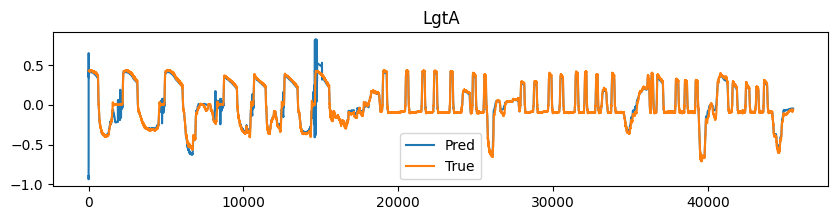

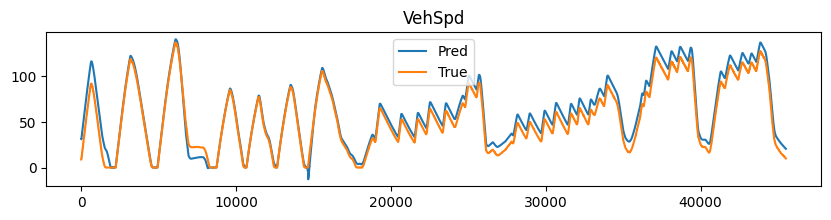

Time Consumed: 0:01:01.371620 s


In [27]:
#Inital Param Benchmark
start_time = datetime.datetime.now()

init_params=np.array([0.042, 0.04, 1.87, 1.87, 0.0017453292519943296, 0.0017453292519943296, 80, 80, 35.25, 18.14, 80, 
            80, 324.0, 1.074, 0.0224, 8818.0, 8818.0, 6818.0, 6818.0])
model_instance=ModelPredict(data,metric_func=customized_metric,show_plots=True)

global metric_benchmark
metric_benchmark=model_instance.run_all_data_metric(init_params)
print('Time Consumed:',datetime.datetime.now()-start_time,'s')

del model_instance

In [28]:
tuned_params

[0.126,
 0.09683697230433826,
 0.6171000000000001,
 0.6171000000000001,
 0.0005759586531581288,
 0.005235987755982989,
 240.0,
 240.0,
 35.306865576146976,
 18.14,
 240.0,
 240.0,
 245.5285670095775,
 3.2220000000000004,
 0.024985293671865656,
 26454.0,
 26454.0,
 20454.0,
 20454.0]

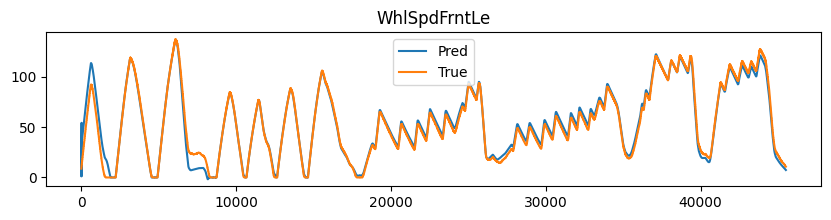

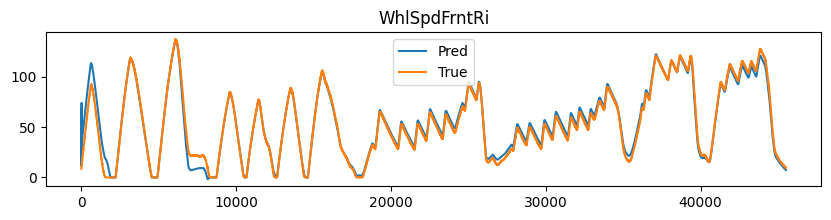

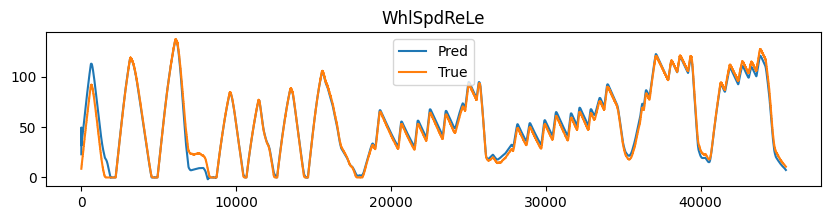

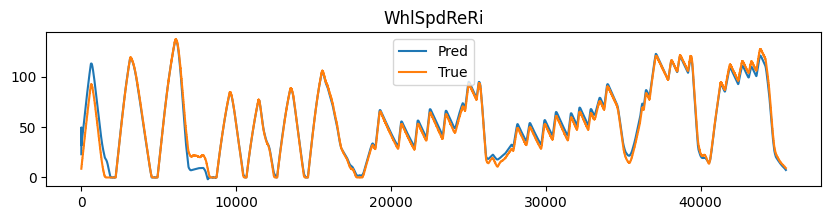

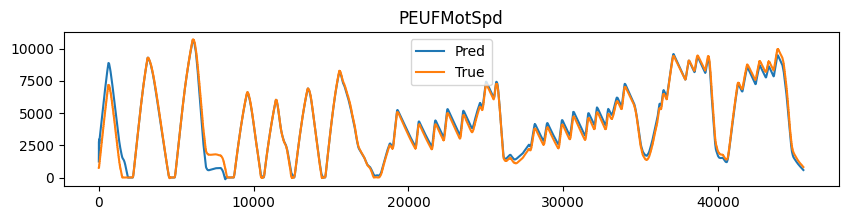

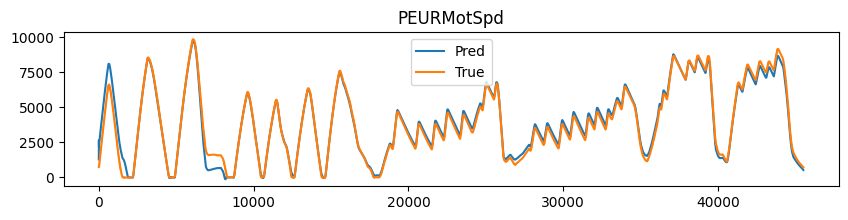

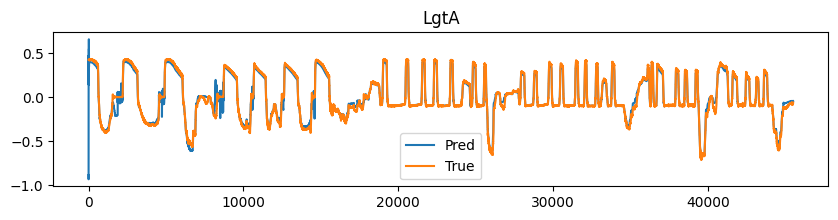

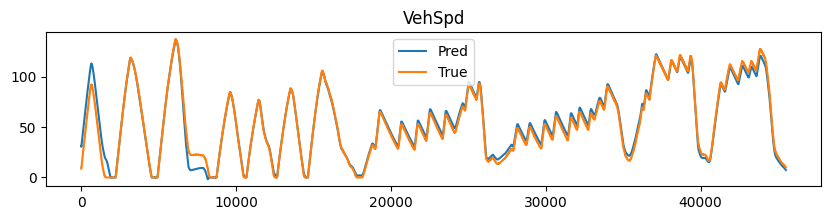

Time Consumed: 0:01:02.625174 s


In [29]:
#Tuned Params
start_time = datetime.datetime.now()

tuned_params=np.array([0.126,
 0.09683697230433826,
 0.6171000000000001,
 0.6171000000000001,
 0.0005759586531581288,
 0.005235987755982989,
 240.0,
 240.0,
 35.306865576146976,
 18.14,
 240.0,
 240.0,
 245.5285670095775,
 3.2220000000000004,
 0.024985293671865656,
 26454.0,
 26454.0,
 20454.0,
 20454.0])
model_instance=ModelPredict(data,metric_func=customized_metric,show_plots=True)


metric_tuned=model_instance.run_all_data_metric(tuned_params)
print('Time Consumed:',datetime.datetime.now()-start_time,'s')

del model_instance

In [30]:
#Performance comparison
performance_table=pd.DataFrame({'InitMae':metric_benchmark.values,'TunedMae':metric_tuned.values,'MaeDeclined':1-metric_tuned.values/metric_benchmark.values})
performance_table.index=metric_benchmark.index
performance_table

,InitMae,TunedMae,MaeDeclined
WhlSpdFrntLe,7.336362,3.118371,0.574943
WhlSpdFrntRi,14.213551,3.075328,0.783634
WhlSpdReLe,7.222489,3.082202,0.573249
WhlSpdReRi,7.877835,3.062527,0.611248
PEUFMotSpd,803.959090,237.786644,0.704230
PEURMotSpd,513.638700,215.647479,0.580157
LgtA,0.020532,0.023066,-0.123396
VehSpd,7.088159,3.010967,0.575212
PEUFMotSpdFollowing,0.009166,0.008999,0.018259
PEURMotSpdFollowing,0.008913,0.008701,0.023784
